# MACD Strategy DataFrame Walkthrough

This notebook walks through how data is transformed in the MACD strategy:
1. Raw Bar objects → DataFrame
2. Add MACD indicators
3. Generate trading signals
4. Tick-by-tick signal lookup

## Step 1: Create Simulated Bar Data

We'll create `Bar` objects matching the real dataclass.

In [1]:
import sys
sys.path.insert(0, '../src')

from dataclasses import dataclass
from datetime import datetime, timedelta
from typing import Optional
from enum import Enum
import numpy as np
import pandas as pd

# Import real types from codebase
from models import Bar, Timeframe, MarketDataPoint

In [2]:
# Check Bar structure
print("Bar fields:")
print(Bar.__dataclass_fields__.keys())

Bar fields:
dict_keys(['symbol', 'timestamp', 'timeframe', 'open', 'high', 'low', 'close', 'volume', 'vwap', 'trade_count'])


In [3]:
# Generate 100 days of simulated price data
np.random.seed(42)  # Reproducible

n_days = 100
start_date = datetime(2024, 1, 1)
start_price = 150.0

# Random walk for prices
returns = np.random.normal(0.001, 0.02, n_days)  # Mean 0.1%, std 2%
prices = start_price * np.cumprod(1 + returns)

# Create Bar objects
bars = []
for i in range(n_days):
    close = prices[i]
    # Simulate OHLC around close
    high = close * (1 + abs(np.random.normal(0, 0.01)))
    low = close * (1 - abs(np.random.normal(0, 0.01)))
    open_price = low + (high - low) * np.random.random()
    
    bar = Bar(
        symbol="AAPL",
        timestamp=start_date + timedelta(days=i),
        timeframe=Timeframe.DAY_1,
        open=round(open_price, 2),
        high=round(high, 2),
        low=round(low, 2),
        close=round(close, 2),
        volume=np.random.randint(1000000, 5000000),
        vwap=round(close * 0.999, 2),
        trade_count=np.random.randint(10000, 50000),
    )
    bars.append(bar)

print(f"Created {len(bars)} Bar objects")
print(f"\nFirst bar:")
print(bars[0])

Created 100 Bar objects

First bar:
Bar(symbol='AAPL', timestamp=datetime.datetime(2024, 1, 1, 0, 0), timeframe=<Timeframe.DAY_1: '1Day'>, open=np.float64(151.34), high=np.float64(153.79), low=np.float64(151.0), close=np.float64(151.64), volume=4011243, vwap=np.float64(151.49), trade_count=10663)


In [4]:
# Examine a few bars
print("First 5 bars:")
for bar in bars[:5]:
    print(f"  {bar.timestamp.date()}: O={bar.open:.2f} H={bar.high:.2f} L={bar.low:.2f} C={bar.close:.2f}")

First 5 bars:
  2024-01-01: O=151.34 H=153.79 L=151.00 C=151.64
  2024-01-02: O=151.20 H=151.62 L=150.76 C=151.37
  2024-01-03: O=154.29 H=156.43 L=153.44 C=153.48
  2024-01-04: O=157.79 H=158.42 L=157.77 C=158.31
  2024-01-05: O=158.14 H=159.99 L=156.05 C=157.73


## Step 2: Convert Bars to DataFrame

Using `FeatureCalculator.bars_to_dataframe()`

In [5]:
from data_loader.features.calculator import FeatureCalculator, FeatureParams

# Convert bars to DataFrame
df = FeatureCalculator.bars_to_dataframe(bars)

print(f"DataFrame shape: {df.shape}")
print(f"Index type: {type(df.index)}")
print(f"\nColumns: {list(df.columns)}")

DataFrame shape: (100, 8)
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>

Columns: ['open', 'high', 'low', 'close', 'volume', 'symbol', 'vwap', 'trade_count']


In [6]:
# View first few rows
df.head()

,open,high,low,close,volume,symbol,vwap,trade_count
timestamp,,,,,,,,
2024-01-01,151.34,153.79,151.00,151.64,4011243,AAPL,151.49,10663
2024-01-02,151.20,151.62,150.76,151.37,4738856,AAPL,151.22,49353
2024-01-03,154.29,156.43,153.44,153.48,4238992,AAPL,153.33,36736
2024-01-04,157.79,158.42,157.77,158.31,2480415,AAPL,158.16,17392
2024-01-05,158.14,159.99,156.05,157.73,3222809,AAPL,157.57,48559


In [7]:
# Check data types
df.dtypes

open           float64
high           float64
low            float64
close          float64
volume           int64
symbol          object
vwap           float64
trade_count      int64
dtype: object

## Step 3: Calculate MACD Indicators

MACD = EMA(12) - EMA(26)  
Signal = EMA(9) of MACD  
Histogram = MACD - Signal

In [8]:
# Calculate MACD features
params = FeatureParams(
    macd_fast=12,
    macd_slow=26,
    macd_signal=9,
)

df_with_macd = FeatureCalculator.calculate(bars, ['macd'], params)

print("New columns added:")
print([col for col in df_with_macd.columns if 'macd' in col.lower()])

New columns added:
['macd', 'macd_signal', 'macd_histogram']


In [10]:
# View MACD columns
df_with_macd[['close', 'macd', 'macd_signal', 'macd_histogram']].head(30)

,close,macd,macd_signal,macd_histogram
timestamp,,,,
2024-01-01,151.64,0.000000,0.000000,0.000000
2024-01-02,151.37,-0.021538,-0.004308,-0.017231
2024-01-03,153.48,0.130151,0.022584,0.107567
2024-01-04,158.31,0.632812,0.144630,0.488183
2024-01-05,157.73,0.973156,0.310335,0.662821
2024-01-06,157.15,1.182449,0.484758,0.697691
2024-01-07,162.27,1.741383,0.736083,1.005300
2024-01-08,164.92,2.370845,1.063035,1.307810
2024-01-09,163.54,2.726910,1.395810,1.331100


In [12]:
# Note: First ~26 rows have NaN (not enough data for slow EMA)
print("NaN counts:")
print(df_with_macd[['macd', 'macd_signal', 'macd_histogram']].isna().sum())

NaN counts:
macd              0
macd_signal       0
macd_histogram    0
dtype: int64


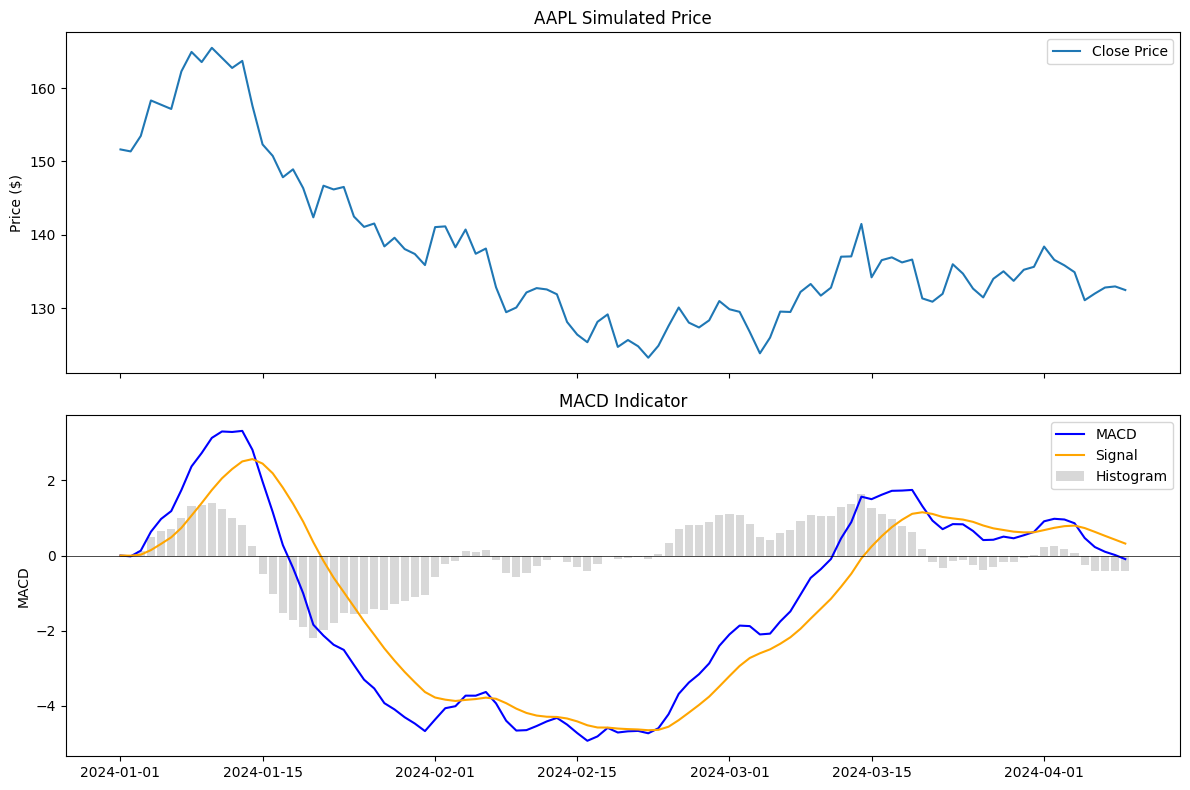

In [13]:
# Visualize MACD
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Price
ax1.plot(df_with_macd.index, df_with_macd['close'], label='Close Price')
ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.set_title('AAPL Simulated Price')

# MACD
ax2.plot(df_with_macd.index, df_with_macd['macd'], label='MACD', color='blue')
ax2.plot(df_with_macd.index, df_with_macd['macd_signal'], label='Signal', color='orange')
ax2.bar(df_with_macd.index, df_with_macd['macd_histogram'], label='Histogram', color='gray', alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_ylabel('MACD')
ax2.legend()
ax2.set_title('MACD Indicator')

plt.tight_layout()
plt.show()

## Step 4: Generate Trading Signals

Detect crossovers:
- **BUY**: MACD crosses above signal line
- **SELL**: MACD crosses below signal line
- **HOLD**: No crossover

In [14]:
from strategy.macd_strategy import MACDStrategy

# Generate signals
df_with_signals = MACDStrategy.generate_signals_from_macd(df_with_macd)

print("Signal column added:")
print(df_with_signals['signal'].value_counts())

Signal column added:
signal
HOLD    91
SELL     5
BUY      4
Name: count, dtype: int64


In [15]:
# View rows with BUY/SELL signals
signals_only = df_with_signals[df_with_signals['signal'] != 'HOLD']
signals_only[['close', 'macd', 'macd_signal', 'signal']]

,close,macd,macd_signal,signal
timestamp,,,,
2024-01-02,151.37,-0.021538,-0.004308,SELL
2024-01-03,153.48,0.130151,0.022584,BUY
2024-01-15,152.32,1.966466,2.445628,SELL
2024-02-04,140.73,-3.727288,-3.840378,BUY
2024-02-07,132.87,-3.931596,-3.810547,SELL
2024-02-23,124.90,-4.593771,-4.636473,BUY
2024-03-21,130.90,0.929790,1.106840,SELL
2024-03-31,135.65,0.628108,0.618383,BUY
2024-04-05,131.10,0.466122,0.730662,SELL


In [16]:
# Understand crossover detection with shift(1)
# Let's examine one BUY signal in detail

if len(signals_only[signals_only['signal'] == 'BUY']) > 0:
    buy_idx = signals_only[signals_only['signal'] == 'BUY'].index[0]
    idx_pos = df_with_signals.index.get_loc(buy_idx)
    
    # Show before and after
    window = df_with_signals.iloc[idx_pos-2:idx_pos+2][['close', 'macd', 'macd_signal', 'signal']]
    print("BUY signal context (MACD crosses above Signal):")
    print(window)
    print(f"\nPrevious bar: MACD ({window.iloc[0]['macd']:.4f}) <= Signal ({window.iloc[0]['macd_signal']:.4f})")
    print(f"Current bar:  MACD ({window.iloc[1]['macd']:.4f}) >  Signal ({window.iloc[1]['macd_signal']:.4f})")

BUY signal context (MACD crosses above Signal):
             close      macd  macd_signal signal
timestamp                                       
2024-01-01  151.64  0.000000     0.000000   HOLD
2024-01-02  151.37 -0.021538    -0.004308   SELL
2024-01-03  153.48  0.130151     0.022584    BUY
2024-01-04  158.31  0.632812     0.144630   HOLD

Previous bar: MACD (0.0000) <= Signal (0.0000)
Current bar:  MACD (-0.0215) >  Signal (-0.0043)


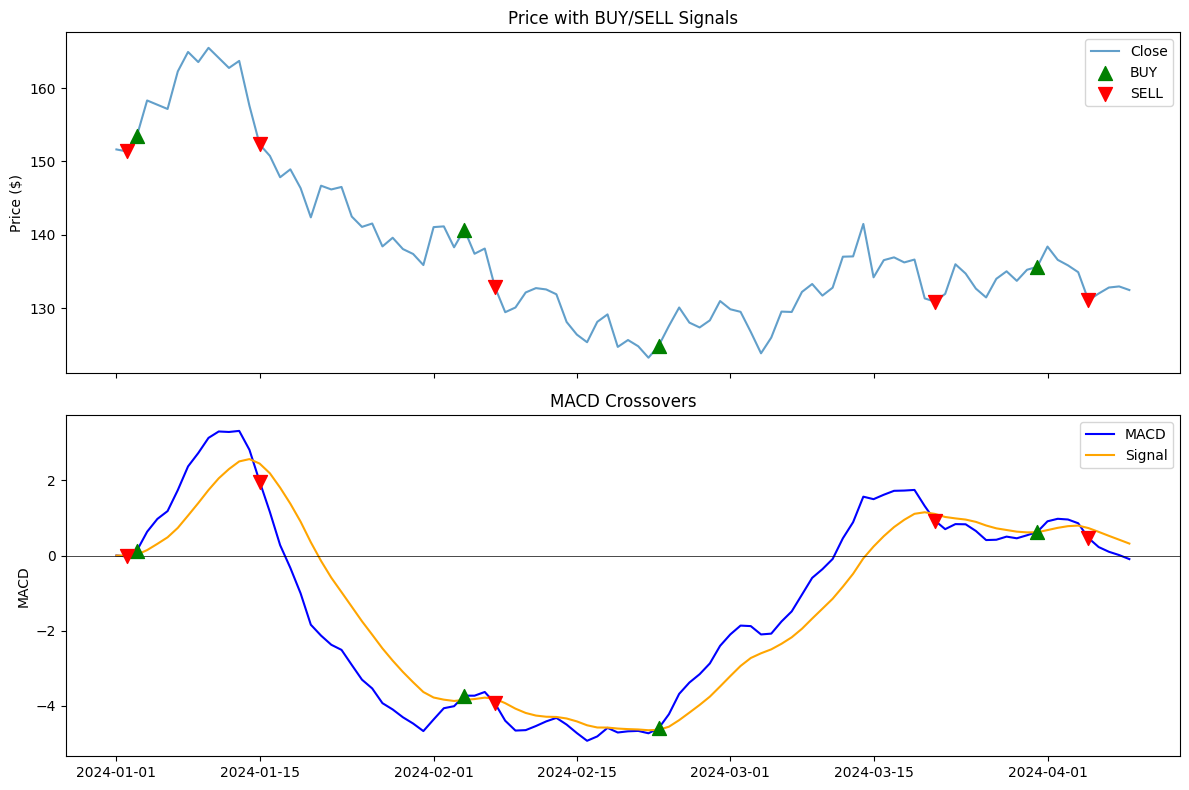

In [17]:
# Visualize signals on price chart
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Price with signals
ax1.plot(df_with_signals.index, df_with_signals['close'], label='Close', alpha=0.7)

# Mark BUY signals
buys = df_with_signals[df_with_signals['signal'] == 'BUY']
ax1.scatter(buys.index, buys['close'], marker='^', color='green', s=100, label='BUY', zorder=5)

# Mark SELL signals  
sells = df_with_signals[df_with_signals['signal'] == 'SELL']
ax1.scatter(sells.index, sells['close'], marker='v', color='red', s=100, label='SELL', zorder=5)

ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.set_title('Price with BUY/SELL Signals')

# MACD with crossover points
ax2.plot(df_with_signals.index, df_with_signals['macd'], label='MACD', color='blue')
ax2.plot(df_with_signals.index, df_with_signals['macd_signal'], label='Signal', color='orange')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Mark crossovers
ax2.scatter(buys.index, buys['macd'], marker='^', color='green', s=100, zorder=5)
ax2.scatter(sells.index, sells['macd'], marker='v', color='red', s=100, zorder=5)

ax2.set_ylabel('MACD')
ax2.legend()
ax2.set_title('MACD Crossovers')

plt.tight_layout()
plt.show()

## Step 5: Tick-by-Tick Signal Lookup

How `generate_signals(tick)` finds the signal for a given timestamp.

In [18]:
# Simulate a tick (as if from live stream)
tick = MarketDataPoint(
    timestamp=datetime(2024, 2, 15),  # Some date in our range
    symbol="AAPL",
    price=155.0,
)

print(f"Incoming tick: {tick}")

Incoming tick: MarketDataPoint(timestamp=datetime.datetime(2024, 2, 15, 0, 0), symbol='AAPL', price=155.0, volume=0.0, bid_price=None, ask_price=None)


In [19]:
# Lookup logic (from MACDStrategy.generate_signals)

df = df_with_signals  # This would be cached in _data_cache

# Check for exact timestamp match
if tick.timestamp in df.index:
    signal = df.loc[tick.timestamp, 'signal']
    print(f"Exact match found: {signal}")
else:
    # Find closest prior timestamp
    prior = df[df.index <= tick.timestamp]
    if not prior.empty:
        signal = prior.iloc[-1]['signal']
        print(f"No exact match. Using closest prior ({prior.index[-1].date()}): {signal}")
    else:
        signal = 'HOLD'
        print(f"No prior data. Default: {signal}")

Exact match found: HOLD


In [20]:
# Test with exact match
exact_tick = MarketDataPoint(
    timestamp=df.index[50],  # Use actual timestamp from data
    symbol="AAPL",
    price=df.iloc[50]['close'],
)

print(f"Tick timestamp: {exact_tick.timestamp}")
print(f"Signal at this timestamp: {df.loc[exact_tick.timestamp, 'signal']}")

Tick timestamp: 2024-02-20 00:00:00
Signal at this timestamp: HOLD


In [21]:
# Create signal dict (as returned by strategy)
def make_signal(action: str, tick: MarketDataPoint) -> dict:
    return {
        'action': action,
        'timestamp': tick.timestamp,
        'symbol': tick.symbol,
        'price': tick.price,
    }

result = make_signal(signal, tick)
print("Signal output:")
result

Signal output:


{'action': 'HOLD',
 'timestamp': datetime.datetime(2024, 2, 15, 0, 0),
 'symbol': 'AAPL',
 'price': 155.0}

## Step 6: Full Strategy Integration

Use the actual `MACDStrategy` class with a mock gateway.

In [22]:
# Create a mock gateway that returns our simulated bars
class MockGateway:
    def __init__(self, bars):
        self._bars = bars
    
    def fetch_bars(self, symbol, timeframe, start, end):
        return [b for b in self._bars if start <= b.timestamp <= end]
    
    def connect(self):
        return True
    
    def disconnect(self):
        pass
    
    def is_connected(self):
        return True

mock_gateway = MockGateway(bars)
print(f"Mock gateway has {len(bars)} bars")

Mock gateway has 100 bars


In [23]:
# Create strategy instance
strategy = MACDStrategy(
    gateway=mock_gateway,
    timeframe=Timeframe.DAY_1,
    fast_period=12,
    slow_period=26,
    signal_period=9,
)

print(f"Strategy created with params:")
print(f"  Fast: {strategy._fast_period}")
print(f"  Slow: {strategy._slow_period}")
print(f"  Signal: {strategy._signal_period}")

Strategy created with params:
  Fast: 12
  Slow: 26
  Signal: 9


In [24]:
# Load data (populates cache)
df_strategy = strategy.get_data(
    symbol="AAPL",
    start=datetime(2024, 1, 1),
    end=datetime(2024, 4, 10),
)

print(f"Loaded {len(df_strategy)} rows")
print(f"Cache keys: {list(strategy._data_cache.keys())}")

Loaded 100 rows
Cache keys: ['AAPL']


In [25]:
# Generate signals for individual ticks (simulating live trading)
test_ticks = [
    MarketDataPoint(timestamp=datetime(2024, 2, 1), symbol="AAPL", price=152.0),
    MarketDataPoint(timestamp=datetime(2024, 2, 15), symbol="AAPL", price=155.0),
    MarketDataPoint(timestamp=datetime(2024, 3, 1), symbol="AAPL", price=158.0),
]

print("Signal generation for each tick:")
print("-" * 50)
for tick in test_ticks:
    signals = strategy.generate_signals(tick)
    print(f"{tick.timestamp.date()}: {signals[0]['action']}")

Signal generation for each tick:
--------------------------------------------------
2024-02-01: HOLD
2024-02-15: HOLD
2024-03-01: HOLD


## Summary

Data transformation pipeline:

```
list[Bar]  →  DataFrame  →  +MACD columns  →  +signal column  →  tick lookup
   │              │              │                  │                │
   │              │              │                  │                └─ O(1) lookup
   │              │              │                  └─ crossover detection
   │              │              └─ EMA calculations (12, 26, 9)
   │              └─ bars_to_dataframe()
   └─ from gateway.fetch_bars()
```